In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from mnist import MNIST
from time import time

In [2]:
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255)
print("Done.")

Loading dataset....
Done.


In [3]:
def one_hot_encode(labels):
    y_inp=np.zeros((len(labels),10))
    for ind,val in enumerate(labels):
        y_inp[ind][val]=1
    return y_inp

In [4]:
def batch_gen(st=0,size=20,validate=False):
    st=st%60000
    if validate:
        X=X_test[st:st+size].reshape(-1,28,28,1)
        labels=y_test[st:st+size]
    else:
        X=X_train[st:st+size].reshape(-1,28,28,1)
        labels=y_train[st:st+size]
    y=one_hot_encode(labels)
    return X,y

# Import network, layers and functions

In [5]:
from network import Sequential,layers
from layers import conv2d,max_pool,flatten,dense
import functions
import numpy as np

# Make Sequential Model

In [30]:
model=Sequential()

In [31]:
model.add(conv2d(input_shape=(28,28,1),num_kernels=8,kernel_size=5,activation=functions.relu))
model.add(max_pool())
model.add(conv2d(num_kernels=16,kernel_size=5,activation=functions.relu))
model.add(max_pool())
model.add(flatten())
model.add(dense(128,activation=functions.relu))
model.add(dense(32,activation=functions.relu))
model.add(dense(10,activation=functions.softmax))

# View Model Summary

In [32]:
model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Name (type)                     Output Shape             Activation        Param #
input_layer (InputLayer)       (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
conv2d (conv2d)                (None, 28, 28, 8)          relu             208
__________________________________________________________________________________________
max_pool (max_pool)            (None, 14, 14, 8)          echo             0
__________________________________________________________________________________________
conv2d (conv2d)                (None, 14, 14, 16)         relu             3216
__________________________________________________________________________________________
max_pool (max_pool)            (None, 7, 7, 16)           echo             0
________________________________________________________________________

# Compile model with optimizer, loss and lr

In [33]:
model.compile(optimizer=functions.iterative,loss=functions.cross_entropy_with_logits,learning_rate=0.01)

# Train model

In [34]:
losses=[]
val_losses=[]
train_acc=[]
val_acc=[]

In [35]:
def run():
    st=0
    btsz=8
    cuts=(((60000*np.arange(11)/10))//btsz)*btsz
    while st<=60000:
        perc=st/600
        ck=np.random.randint(0,60000-btsz)
        inp,y_inp=batch_gen(ck,size=btsz)
        logits=model.fit(inp,y_inp)
        ans=logits.argmax(axis=1)
        cor=y_inp.argmax(axis=1)
        acc=100*(ans==cor).mean()
#         cross_entropy_loss=model.loss(logits=logits,labels=y_inp).mean()
        cross_entropy_loss=functions.mean_squared_error(logits,labels=y_inp).mean()
        losses.append(cross_entropy_loss)
        train_acc.append(acc)
        print("\rProgress: {:.2f} %\tAcc: {:.2f} %\tloss: {:.4f}".format(perc,acc,cross_entropy_loss),end='')
        if st in cuts:
            print("\nCalculating Validation acc...",end='')
            sz=4000
#             ck=0
            ck=np.random.randint(0,10000-sz)
            inp,y_inp=batch_gen(ck,size=sz,validate=True)
            logits=model.predict(inp)
            ans=logits.argmax(axis=1)
            cor=y_inp.argmax(axis=1)
            acc=100*(ans==cor).mean()
#             cross_entropy_loss=model.loss(logits=logits,labels=y_inp).mean()
            cross_entropy_loss=model.loss(logits,labels=y_inp).mean()
            print("\rValidation Acc: {:.2f} %\t\tVal loss: {:.4f}".format(acc,cross_entropy_loss))
            val_losses.append(cross_entropy_loss)
            val_acc.append(acc)
            if acc>=96:
                model.learning_rate=0.00001
            elif acc>=93:
                model.learning_rate=0.0001
            elif acc>=90:
                model.learning_rate=0.001
        st+=btsz

In [36]:
for i in range(2):
    run()

Progress: 0.00 %	Acc: 12.50 %	loss: 0.0924
Validation Acc: 10.00 %		Val loss: 0.2361
Progress: 10.00 %	Acc: 87.50 %	loss: 0.0305
Validation Acc: 88.98 %		Val loss: 0.0346
Progress: 20.00 %	Acc: 87.50 %	loss: 0.02372
Validation Acc: 88.30 %		Val loss: 0.0353
Progress: 30.00 %	Acc: 87.50 %	loss: 0.01533
Validation Acc: 90.03 %		Val loss: 0.0332
Progress: 40.00 %	Acc: 100.00 %	loss: 0.0001
Validation Acc: 94.03 %		Val loss: 0.0194
Progress: 50.00 %	Acc: 100.00 %	loss: 0.0001
Validation Acc: 94.42 %		Val loss: 0.0179
Progress: 60.00 %	Acc: 100.00 %	loss: 0.0088
Validation Acc: 95.53 %		Val loss: 0.0147
Progress: 70.00 %	Acc: 100.00 %	loss: 0.0010
Validation Acc: 94.70 %		Val loss: 0.0174
Progress: 80.00 %	Acc: 100.00 %	loss: 0.0001
Validation Acc: 97.70 %		Val loss: 0.0081
Progress: 80.83 %	Acc: 100.00 %	loss: 0.0023

KeyboardInterrupt: 

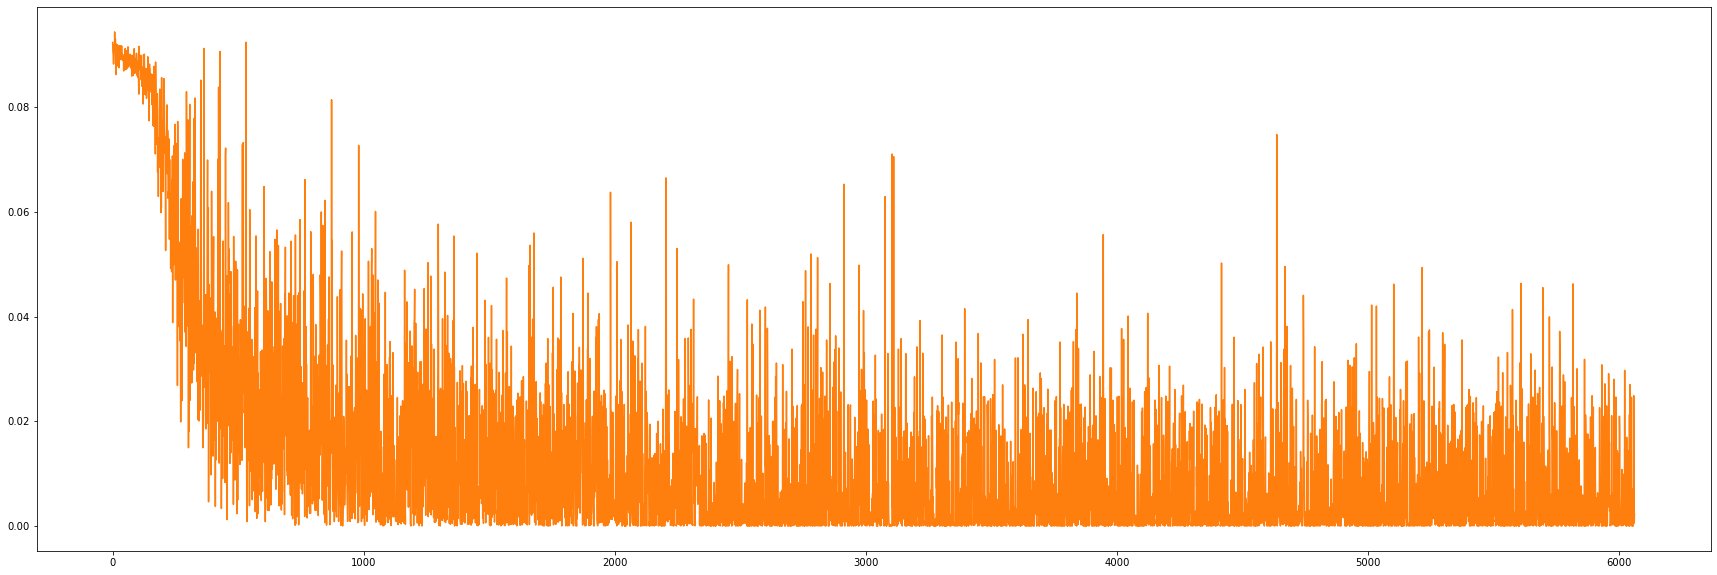

In [39]:
plt.figure(figsize=(30,10))
plt.plot(losses,color='#ff7f0e')
plt.show()

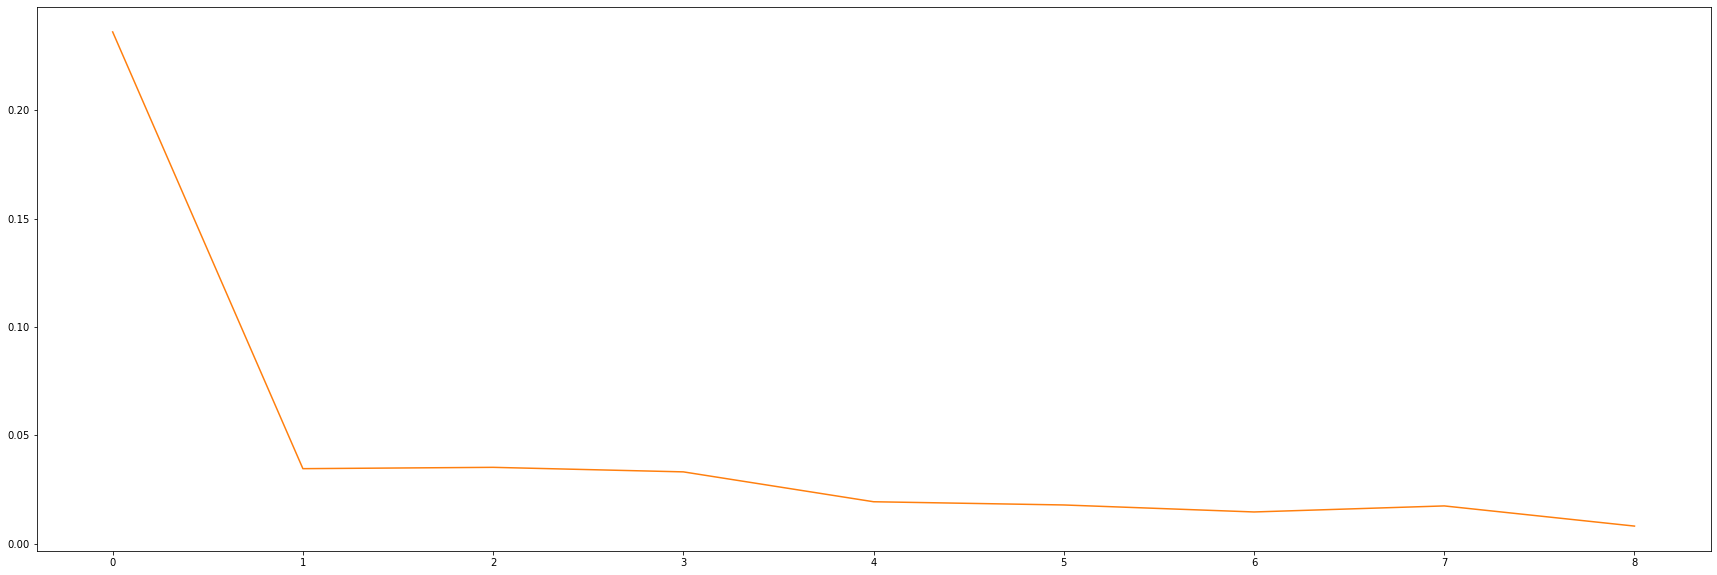

In [40]:
plt.figure(figsize=(30,10))
plt.plot(val_losses,color='#ff7f0e')
plt.show()

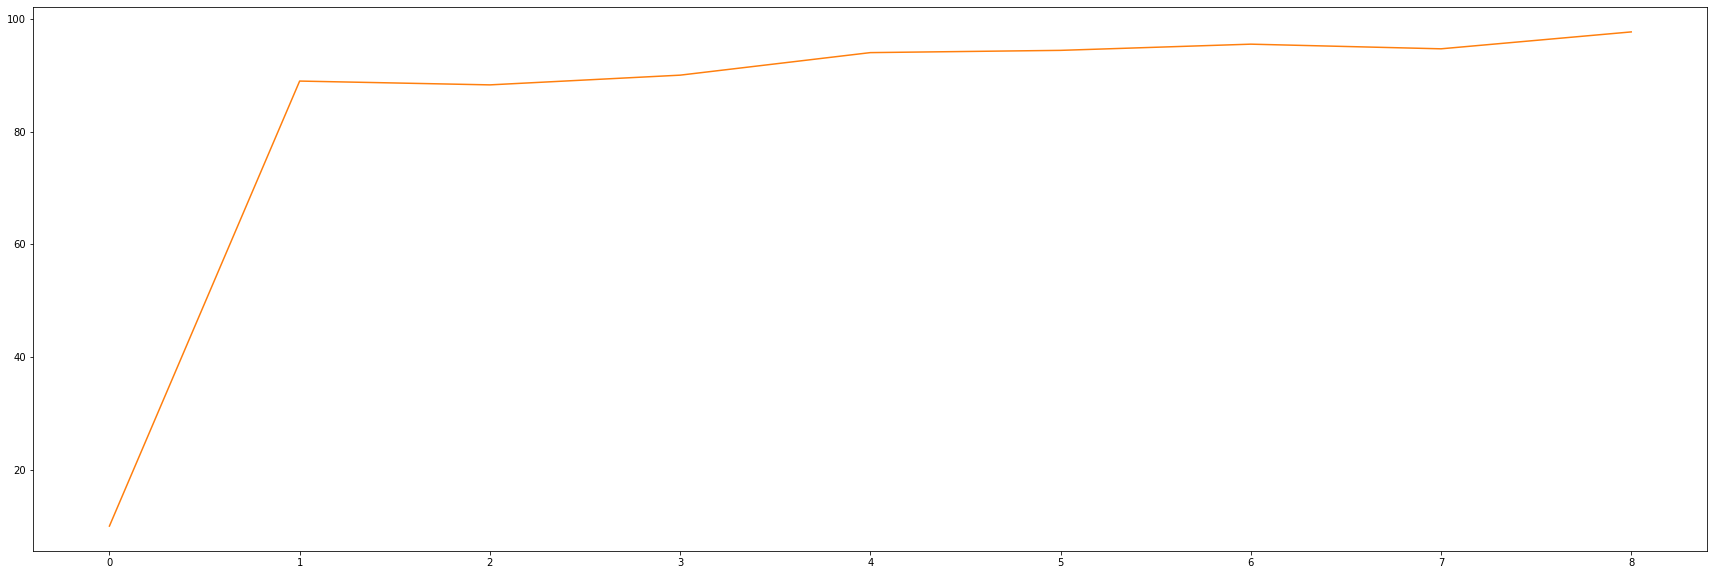

In [41]:
plt.figure(figsize=(30,10))
plt.plot(val_acc,color='#ff7f0e')
plt.show()

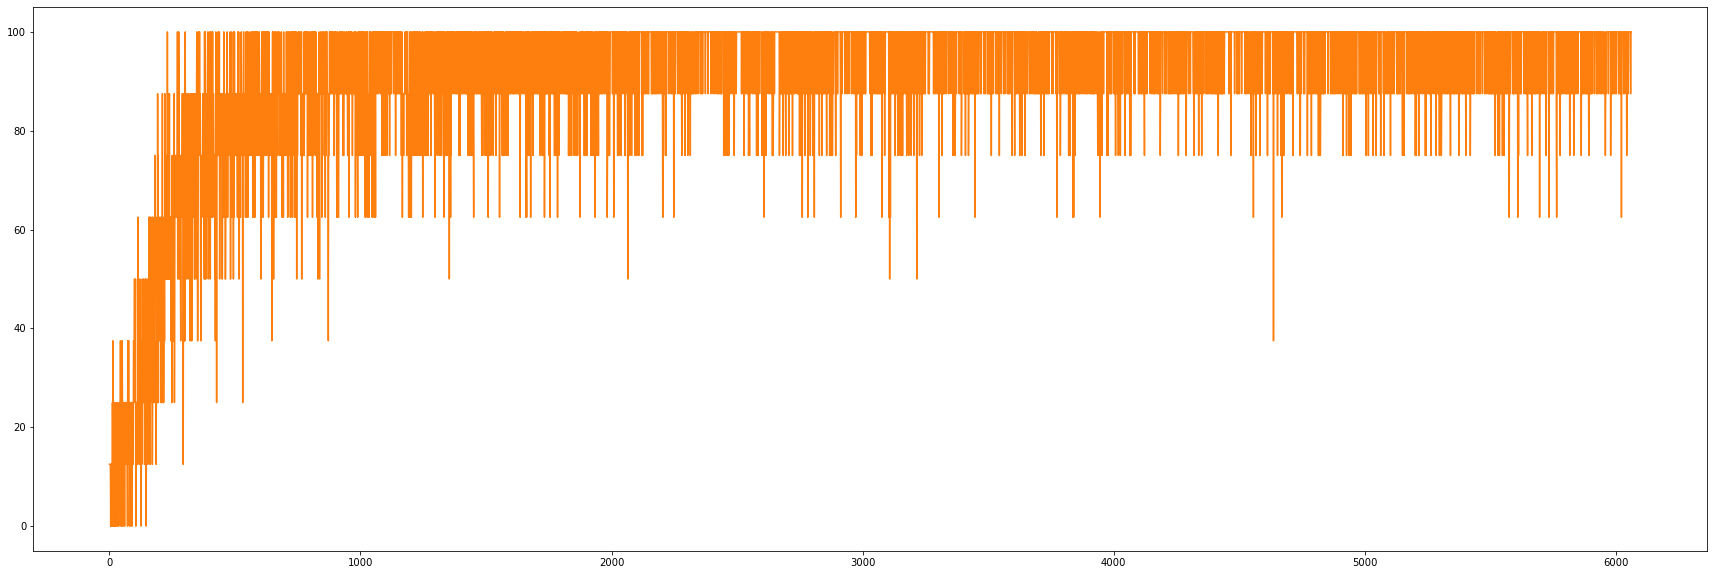

In [42]:
plt.figure(figsize=(30,10))
plt.plot(train_acc,color='#ff7f0e')
plt.show()

Prediction: [5] 
Correct:    [5]


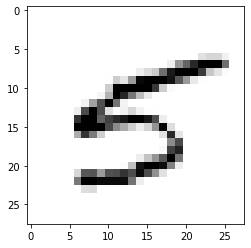

In [46]:
ck=np.random.randint(0,60000-100)
inp,y_inp=batch_gen(ck,size=1)
logits=model.predict(inp)
ans=logits.argmax(axis=1)
cor=y_inp.argmax(axis=1)
print("Prediction:",ans,"\nCorrect:   ",cor)
plt.imshow(inp[0].reshape(28,28), cmap='Greys')

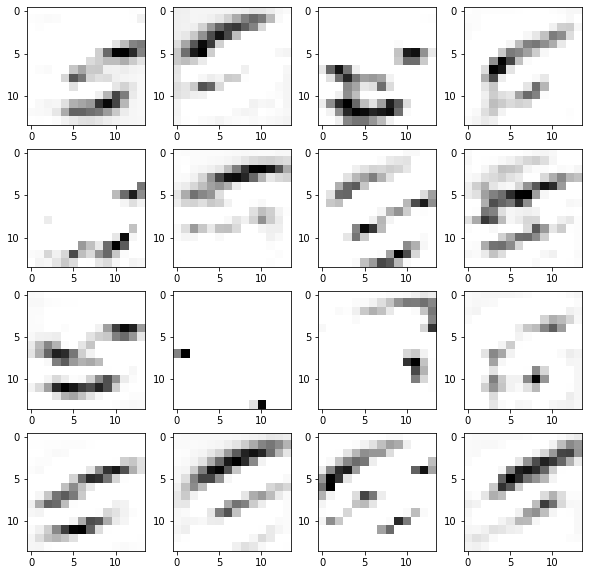

In [49]:
fig, ax = plt.subplots(nrows=4,ncols=4,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=model.sequence[2].z_out.transpose(3,0,1,2)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')